# Eye Tracking Data Analysis Project

This project is prepared for BDA 502 - Introduction to Machine Learning Course

Group Members:

    * YUDUM PAÇİN
    * YIĞIT ONAY 
    * EGEMEN ONAT ATAM 
    * HACI BAYRAM SAYGILI 
    * ARDA TANRIVERDI

## Table of Contents:
* [Data](#first-bullet)
* [Data Preprocess](#second-bullet)
* [Statistical Analysis](#second-bullet)
* [Machine Learning](#second-bullet)

Eye Tracking Data source, given [link](https://drive.google.com/drive/folders/1-IONyJb2HClD2KfeJtVgrsV4IMwJsd26?usp=share_link) is in csv formatted 80 files with approximately 50000 rows for each, consisting of participants of Eye Tracking Experiment.

[Eye_Tracking_Data.ipynb](http://localhost:8888/notebooks/Documents/GitHub/eye_tracking_data_project/eye_tracking_data_project/Eye_Tracking_Data.ipynb) file consists of codes we used for downloading these csv files, converting them to Pandas dataframes and saving it as pickles. 

In this file, data preprocess steps below are applied before saving the file.


* TIME, FPOGX, FPOGY, FPOGS, FPOGD, FPOGID, FPOGV, LPUPILD, LPUPILV, RPUPILD, RPUPILV, USER columns kept
* Any values that do not contain STIMULI_ONSET string under the USER column were deleted.


In these part of the analysis, we continue to data analysis of eye tracking data step by step

In [1]:
#import necessary libraries
import pickle
import bz2
import gzip
import lzma
import pickle
import numpy as np
import pandas as pd
import math
import seaborn as sns
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter

### emrec_data: summary of participant informations

In [105]:
#load the summary participant data
with open('emorec_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [106]:
data.head()

,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
0,1,28,F,control,67.600,0.970,High IAcc,0.850,0.570,0.500,0.500,2.420
1,2,28,F,self,75.600,0.750,High IAcc,0.500,0.600,0.450,0.500,2.050
2,3,25,F,self,75.000,0.700,High IAcc,1.000,0.870,0.370,0.000,2.240
3,4,26,F,self,84.300,0.910,High IAcc,0.550,0.220,0.420,0.140,1.330
4,5,30,F,self,67.300,0.810,High IAcc,0.600,0.420,0.370,0.420,1.810


In [107]:
data.shape

(80, 12)

### participants data: eye tracking experiments data of all participants

In [108]:
# open participants_compressed.pbz2
with bz2.open('participants_compressed.pbz2', 'rb') as f:
    participants = pickle.load(f)

In [109]:
participants.head()

,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,FileName
2883,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2884,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2885,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2886,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e
2887,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,emorecm4623_e


In [7]:
participants.shape

(3409501, 13)

In [125]:
len(np.unique(participants.FileName)) * len(np.unique(participants.USER)) 

2560

### sample data

In [110]:
sample_data = pd.read_excel("Sample Analyses_507.xlsx")

In [111]:
sample_data.head()

,PARTICIPANT,GROUP (Control or self),STIMULI,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY,DURATION,FIXATION_VALIDATION,TOTAL_FIXATION_DURATION,FIXATION_DURATION_PER_COUNT,TOTAL_FIXATION_COUNT,PUPIL_DILATION,RIGHT_PUPIL_DILATION_VALIDATION,LEFT_PUPIL_DILATION_VALIDATION,TOTAL_SACCADE/SECOND
0,1,control,1,High,F,SAD,SAD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,control,2,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,control,3,High,F,ANGRY,ANGRY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,control,4,High,F,ANGRY,NEUTRAL,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,control,5,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
sample_data.shape

(2208, 17)

## Preprocess the Data

In [112]:
# Validating if ratio of valid data is above 70% - possible exclusion of users.
data_1 = pd.pivot_table(participants, values=["FPOGV"], index=["FileName","USER"], aggfunc=[np.sum, "count"])
data_1["ratio"] = data_1["sum"] / data_1["count"]
data_1

sum count ratio
                                 FPOGV FPOGV      
FileName      USER                                
emorecF1029_e STIMULI_ONSET1   846.000  1212 0.698
              STIMULI_ONSET10 1136.000  1565 0.726
              STIMULI_ONSET11  777.000  1062 0.732
              STIMULI_ONSET12 1461.000  1989 0.735
              STIMULI_ONSET13  953.000  1377 0.692
...                                ...   ...   ...
emorecm920_e  STIMULI_ONSET5   926.000  1061 0.873
              STIMULI_ONSET6  1891.000  2176 0.869
              STIMULI_ONSET7   403.000   448 0.900
              STIMULI_ONSET8  1956.000  2271 0.861
              STIMULI_ONSET9  1213.000  1360 0.892

[2560 rows x 3 columns]

In [113]:
data_1 = data_1.reset_index()

In [114]:
# control ratio of valid data, flagged as FPOGV=1, is grater than 70%
data_1[data_1.ratio<0.7]

,FileName,USER,sum,count,ratio
,,,FPOGV,FPOGV,
0,emorecF1029_e,STIMULI_ONSET1,846.000,1212,0.698
4,emorecF1029_e,STIMULI_ONSET13,953.000,1377,0.692
11,emorecF1029_e,STIMULI_ONSET2,423.000,618,0.684
21,emorecF1029_e,STIMULI_ONSET29,655.000,997,0.657
25,emorecF1029_e,STIMULI_ONSET32,341.000,494,0.690
...,...,...,...,...,...
2486,emorecm7826_e,STIMULI_ONSET3,730.000,1061,0.688
2489,emorecm7826_e,STIMULI_ONSET32,1230.000,1806,0.681
2493,emorecm7826_e,STIMULI_ONSET7,555.000,996,0.557


In [115]:
data_filter_7 = data_1[data_1.ratio>0.7]

In [116]:
data_filter_7

,FileName,USER,sum,count,ratio
,,,FPOGV,FPOGV,
1,emorecF1029_e,STIMULI_ONSET10,1136.000,1565,0.726
2,emorecF1029_e,STIMULI_ONSET11,777.000,1062,0.732
3,emorecF1029_e,STIMULI_ONSET12,1461.000,1989,0.735
5,emorecF1029_e,STIMULI_ONSET14,334.000,448,0.746
6,emorecF1029_e,STIMULI_ONSET15,986.000,1229,0.802
...,...,...,...,...,...
2555,emorecm920_e,STIMULI_ONSET5,926.000,1061,0.873
2556,emorecm920_e,STIMULI_ONSET6,1891.000,2176,0.869
2557,emorecm920_e,STIMULI_ONSET7,403.000,448,0.900


In [117]:
data_filtered_0 = participants[(participants.FileName.isin(data_filter_7.FileName)) & (participants.USER.isin(data_filter_7.USER))]

In [118]:
# Filtering with respect to non-null values of FPOGV, LPUPILV and RPUPILV

data_filtered = data_filtered_0.loc[(data_filtered_0["FPOGV"] == 1) & (data_filtered_0["LPUPILV"] == 1) & (data_filtered_0["RPUPILV"] == 1),:]

In [119]:
#get the final preprocessed data
df_prep = data_filtered.copy()

## The Butterworth low-pass filter

In [120]:
##############################################################
#                                                            #
#    Mark Hoogendoorn and Burkhardt Funk (2017)              #
#    Machine Learning for the Quantified Self                #
#    Springer                                                #
#    Chapter 3                                               #
#                                                            #
##############################################################

from sklearn.decomposition import PCA

from scipy.signal import butter, lfilter, filtfilt

def low_pass_filter(data_table, col, sampling_frequency, cutoff_frequency, order=5, phase_shift=True):
    # http://stackoverflow.com/questions/12093594/how-to-implement-band-pass-butterworth-filter-with-scipy-signal-butter
    # Cutoff frequencies are expressed as the fraction of the Nyquist frequency, which is half the sampling frequency
    nyq = 0.5 * sampling_frequency
    cut = cutoff_frequency / nyq

    b, a = butter(order, cut, btype='low', output='ba', analog=False)
    if phase_shift:
        data_table[col + '_lowpass'] = filtfilt(b, a, data_table[col])
    else:
        data_table[col + '_lowpass'] = lfilter(b, a, data_table[col])
    return data_table

### Examine TIME frequency

In [121]:
np.diff(participants[participants.FileName=="emorecm4623_e"].sort_values(by="TIME")["TIME"]).mean()

0.01714582569034753

In [122]:
np.diff(participants[participants.FileName=="emorec_ctrlF6721_e"].sort_values(by="TIME")["TIME"]).mean()

0.01761143484626647

In [123]:
df_prep["max_pupild"] = df_prep[["LPUPILD", "RPUPILD"]].max(axis=1)
fs = 60
cutoff = 0.5
fs = 1000/200
cutoff = 1
df_low_pass_final = low_pass_filter(df_prep.groupby("USER").mean(),"max_pupild", fs, cutoff)[["max_pupild", "max_pupild_lowpass"]]

## Calculate z-scores

<AxesSubplot:xlabel='USER'>

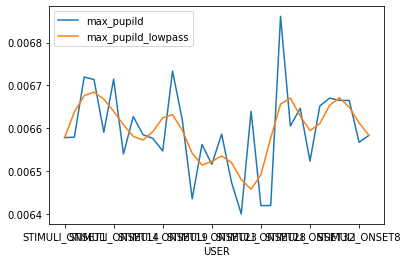

In [124]:
df_low_pass_final["z_score"] = (df_low_pass_final["max_pupild"] - np.mean(df_low_pass_final["max_pupild"])) / np.std(df_low_pass_final["max_pupild"])
df_low_pass_final[["max_pupild", "max_pupild_lowpass"]].plot()

<AxesSubplot:xlabel='USER'>

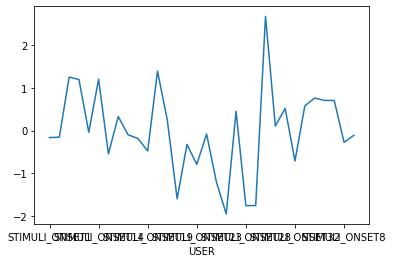

In [125]:
df_low_pass_final["z_score"].plot()

## Calculate And Add Fixation Count and Fixation Duration

In [143]:
def calculate_fixation_count(df):
    data = df.copy()
    data = data.sort_values(["USER","TIME"])

    # Specify fixation radius and minimum duration
    fixation_radius = 58
    min_duration = 0.12
    results = []

    # Get unique trial names
    trials = data['USER'].unique()
    participants = data["FileName"].unique()

    # Loop through trials and calculate fixation count and duration
    for participant in participants:
        print(participant + " : start")
        for trial in trials:
            print(str(trial) + ": start")
            result = {}
            trial_data = data[data['USER'] == trial]
            fixation_count = 0
            fixation_duration = 0
            last_fixation_end_time = float('nan')
            last_x = last_y = 0

            for index, row in trial_data.iterrows():
                
                x = row['FPOGX'] * 1920  # Convert fraction of screen to pixels
                y = row['FPOGY'] * 1080  # Convert fraction of screen to pixels

                if math.isnan(last_fixation_end_time):
                    # First sample in trial
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = fixation_start_time
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time <= min_duration:
                    # Continuing fixation
                    pass
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) <= fixation_radius and \
                        row['FPOGS'] - last_fixation_end_time > min_duration:
                    # Extended fixation
                    fixation_duration += row['FPOGS'] - last_fixation_end_time
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']
                elif math.sqrt((x - last_x) ** 2 + (y - last_y) ** 2) > fixation_radius:
                    # New fixation
                    fixation_count += 1
                    fixation_duration += row['FPOGD']
                    fixation_start_time = row['FPOGS']
                    last_fixation_end_time = row['FPOGS'] + row['FPOGD']

                last_x = x
                last_y = y

            # Print results for trial
            #print(f"Trial: {trial}, Fixation Count: {fixation_count}, Fixation Duration: {fixation_duration:.2f} seconds")
            result["trial"] = trial
            result["FileName"] = participant
            result["fixation_count"] = fixation_count
            result["fixation_duration"] = fixation_duration
            results.append(result)
        
    
    return results

In [144]:
results = calculate_fixation_count(df_prep)

emorecF4e25_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorecF1531_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start


STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlF3730_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlm7919_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15:

STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlF2822_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorecm8322_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
S

STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorecm1820_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlm2922_e : start
STIMULI_ONSET1: start
S

STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorecm6824_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIM

STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlF5530_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: st

STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: start
STIMULI_ONSET4: start
STIMULI_ONSET5: start
STIMULI_ONSET6: start
STIMULI_ONSET7: start
STIMULI_ONSET8: start
STIMULI_ONSET9: start
emorec_ctrlF5024_e : start
STIMULI_ONSET1: start
STIMULI_ONSET10: start
STIMULI_ONSET11: start
STIMULI_ONSET12: start
STIMULI_ONSET13: start
STIMULI_ONSET14: start
STIMULI_ONSET15: start
STIMULI_ONSET16: start
STIMULI_ONSET17: start
STIMULI_ONSET18: start
STIMULI_ONSET19: start
STIMULI_ONSET2: start
STIMULI_ONSET20: start
STIMULI_ONSET21: start
STIMULI_ONSET22: start
STIMULI_ONSET23: start
STIMULI_ONSET24: start
STIMULI_ONSET25: start
STIMULI_ONSET26: start
STIMULI_ONSET27: start
STIMULI_ONSET28: start
STIMULI_ONSET29: start
STIMULI_ONSET3: start
STIMULI_ONSET30: start
STIMULI_ONSET31: start
STIMULI_ONSET32: 

In [145]:
results_df = pd.DataFrame(results)

In [146]:
df_fix = pd.merge(results_df, df_prep, left_on=["trial","FileName"], right_on = ["USER","FileName"])

In [147]:
df_fix.head()

,trial,FileName,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,USER,max_pupild
0,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.905,0.500,0.479,125.728,0.177,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
1,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.920,0.501,0.478,125.728,0.193,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
2,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.938,0.501,0.477,125.728,0.210,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
3,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.953,0.500,0.475,125.728,0.226,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006
4,STIMULI_ONSET1,emorecF4e25_e,72220,36525.142,125.969,0.500,0.475,125.728,0.242,242.000,1.000,0.006,1.000,0.006,1.000,STIMULI_ONSET1,0.006


## Saccade Calculation

In [148]:
def calculate_saccade(df):
    data = df.copy()
    results = []
    data = data.sort_values(["USER","TIME"])

    # Get unique trial names
    trials = data['USER'].unique()
    participants = data["FileName"].unique()

    # Loop through trials and calculate saccade
    for participant in participants:
        for trial in trials:
            result = {}
            trial_data = data[data['USER'] == trial]

            delta_t = np.array(np.diff(trial_data['TIME']), dtype=np.float64) / 1000.0
            delta_x = np.array(np.diff(trial_data['FPOGX']), dtype=np.float64)
            delta_y = np.array(np.diff(trial_data['FPOGY']), dtype=np.float64)
            velocity = np.sqrt(delta_x**2 + delta_y**2) / delta_t

            # Set a velocity threshold for saccade detection
            velocity_threshold = 30.0  # degrees per second

            # Calculate saccades
            saccade = (velocity > velocity_threshold).sum()
            saccade_per_sec = saccade / (trial_data['TIME'].iloc[-1] - trial_data['TIME'].iloc[0]) * 1000.0
            result["USER"] = trial
            result["FileName"] = participant
            result["saccade_per_sec"] = saccade_per_sec
            results.append(result)
        
    return results


In [149]:
data_saccade_ = calculate_saccade(df_fix)

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_11280\2082225531.py:19: RuntimeWarning: divide by zero encountered in true_divide
  velocity = np.sqrt(delta_x**2 + delta_y**2) / delta_t


In [150]:
results_df_S = pd.DataFrame(data_saccade_)

In [151]:
data_saccade = pd.merge(results_df_S, df_fix, left_on=["USER","FileName"], right_on = ["USER","FileName"])

In [152]:
data_saccade.to_pickle("df.pkl")

In [10]:
data_saccade = pd.read_pickle("df.pkl")

In [12]:
data_saccade.head()

,USER,FileName,saccade_per_sec,trial,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,max_pupild
0,STIMULI_ONSET1,emorecF4e25_e,15699.369,STIMULI_ONSET1,72220,36525.142,125.905,0.500,0.479,125.728,0.177,242.000,1.000,0.006,1.000,0.006,1.000,0.006
1,STIMULI_ONSET1,emorecF4e25_e,15699.369,STIMULI_ONSET1,72220,36525.142,125.920,0.501,0.478,125.728,0.193,242.000,1.000,0.006,1.000,0.006,1.000,0.006
2,STIMULI_ONSET1,emorecF4e25_e,15699.369,STIMULI_ONSET1,72220,36525.142,125.938,0.501,0.477,125.728,0.210,242.000,1.000,0.006,1.000,0.006,1.000,0.006
3,STIMULI_ONSET1,emorecF4e25_e,15699.369,STIMULI_ONSET1,72220,36525.142,125.953,0.500,0.475,125.728,0.226,242.000,1.000,0.006,1.000,0.006,1.000,0.006
4,STIMULI_ONSET1,emorecF4e25_e,15699.369,STIMULI_ONSET1,72220,36525.142,125.969,0.500,0.475,125.728,0.242,242.000,1.000,0.006,1.000,0.006,1.000,0.006


## Statistical Analysis

1.	Participants with high vs low interoceptive awareness (ANOVA, Post-hoc, T-Tests, Correlation)

* Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, gender and accuracy scores. 

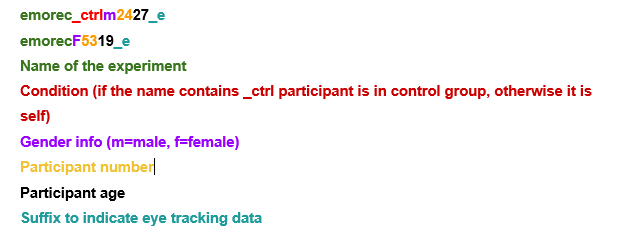

### Prepare the data for Statistical Analysis

In [13]:
data["FileName"] = "emorec" + data.apply(lambda row: "_ctrl" if row["condition"] =="control" else '', axis=1)+data.apply(lambda row: 'F' if row["subgender"]=='F' else 'm',axis=1)+data.subid.astype("str")+data.subage.astype("str")+"_e"

In [14]:
data["FileName"] = data["FileName"].str.lower()
data_saccade["FileName"] = data_saccade["FileName"].str.lower()

In [15]:
df_tam = pd.merge(data_saccade,data, left_on="FileName", right_on="FileName")

In [16]:
pd.set_option('display.max_columns', None)

In [17]:
np.unique(df_tam.subid.value_counts().index)

array([ 1,  2,  4,  5,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21,
       22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 73, 74, 76,
       78, 79, 80, 81, 82, 83], dtype=int64)

In [18]:
df_tam[df_tam.FileName=='emorecm4623_e'].sort_values(by="TIME")

,USER,FileName,saccade_per_sec,trial,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,max_pupild,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total
71139,STIMULI_ONSET1,emorecm4623_e,15699.369,STIMULI_ONSET1,72220,36525.142,148.152,0.498,0.464,147.791,0.361,257.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71140,STIMULI_ONSET1,emorecm4623_e,15699.369,STIMULI_ONSET1,72220,36525.142,148.170,0.498,0.461,147.791,0.379,257.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71141,STIMULI_ONSET1,emorecm4623_e,15699.369,STIMULI_ONSET1,72220,36525.142,148.186,0.498,0.459,147.791,0.395,257.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71142,STIMULI_ONSET1,emorecm4623_e,15699.369,STIMULI_ONSET1,72220,36525.142,148.202,0.498,0.457,147.791,0.412,257.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
71143,STIMULI_ONSET1,emorecm4623_e,15699.369,STIMULI_ONSET1,72220,36525.142,148.221,0.498,0.456,147.791,0.430,257.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91035,STIMULI_ONSET32,emorecm4623_e,12417.652,STIMULI_ONSET32,58787,22140.924,839.501,0.526,0.425,839.304,0.197,1469.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91036,STIMULI_ONSET32,emorecm4623_e,12417.652,STIMULI_ONSET32,58787,22140.924,839.518,0.526,0.424,839.304,0.213,1469.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91037,STIMULI_ONSET32,emorecm4623_e,12417.652,STIMULI_ONSET32,58787,22140.924,839.536,0.526,0.422,839.304,0.232,1469.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210
91038,STIMULI_ONSET32,emorecm4623_e,12417.652,STIMULI_ONSET32,58787,22140.924,839.550,0.527,0.419,839.304,0.246,1469.000,1.000,0.006,1.000,0.006,1.000,0.006,46,23,M,self,105.000,0.760,High IAcc,0.500,1.000,0.550,0.160,2.210


In [19]:
df_tam["STIMULI"] = df_tam["USER"].str.replace("STIMULI_ONSET","").astype("int")

In [20]:
df_tam.head()

,USER,FileName,saccade_per_sec,trial,fixation_count,fixation_duration,TIME,FPOGX,FPOGY,FPOGS,FPOGD,FPOGID,FPOGV,LPUPILD,LPUPILV,RPUPILD,RPUPILV,max_pupild,subid,subage,subgender,condition,heartbeats (actual) mean,IAcc,IAcc HighvsLow,sadnessAcc,neutralAcc,happinessAcc,angerAcc,emorec total,STIMULI
0,STIMULI_ONSET1,emorecf1531_e,15699.369,STIMULI_ONSET1,72220,36525.142,132.047,0.485,0.415,131.669,0.378,243.000,1.000,0.005,1.000,0.005,1.000,0.005,15,31,F,self,128.300,0.640,Low IAcc,0.550,0.830,0.440,0.500,2.320,1
1,STIMULI_ONSET1,emorecf1531_e,15699.369,STIMULI_ONSET1,72220,36525.142,132.063,0.485,0.416,131.669,0.394,243.000,1.000,0.005,1.000,0.005,1.000,0.005,15,31,F,self,128.300,0.640,Low IAcc,0.550,0.830,0.440,0.500,2.320,1
2,STIMULI_ONSET1,emorecf1531_e,15699.369,STIMULI_ONSET1,72220,36525.142,132.080,0.485,0.416,131.669,0.411,243.000,1.000,0.005,1.000,0.005,1.000,0.005,15,31,F,self,128.300,0.640,Low IAcc,0.550,0.830,0.440,0.500,2.320,1
3,STIMULI_ONSET1,emorecf1531_e,15699.369,STIMULI_ONSET1,72220,36525.142,132.097,0.484,0.416,131.669,0.427,243.000,1.000,0.005,1.000,0.005,1.000,0.005,15,31,F,self,128.300,0.640,Low IAcc,0.550,0.830,0.440,0.500,2.320,1
4,STIMULI_ONSET1,emorecf1531_e,15699.369,STIMULI_ONSET1,72220,36525.142,132.115,0.484,0.414,131.669,0.446,243.000,1.000,0.005,1.000,0.005,1.000,0.005,15,31,F,self,128.300,0.640,Low IAcc,0.550,0.830,0.440,0.500,2.320,1


In [21]:
df_tam.shape

(2371004, 31)

In [22]:
df_tam = df_tam.sort_values(['STIMULI', 'TIME'])

In [ ]:
    ('fixation_duration','fixation_count'): [('fixation_duration_per_count',lambda x: x[0]/x[1])],
    ('RPUPILV','LPUPILV'): [('pupil_dilation', lambda x: x.mean().mean())],

In [57]:
results = df_tam.groupby(["STIMULI","subid"]).agg({
    'TIME': [('DURATION', lambda x: x.iloc[-1] - x.iloc[0])],
    'FPOGV': [('fixation_validation', lambda x: x.sum())],
    'fixation_duration': [('total_fixation_duration', lambda x: x.sum())],
    'fixation_count': [('total_fixation_count', lambda x: x.sum())],
    'RPUPILV': [('right_pupil_dilation_validation', lambda x: x.sum())],
    'LPUPILV': [('left_pupil_dilation_validation', lambda x: x.sum())],
    'saccade_per_sec': [('total_saccade_second', lambda x: x.sum())]
})

In [59]:
results.columns = [col[0] if col[-1] == '' else col[-1] for col in results.columns]

In [60]:
results = results.reset_index()

In [61]:
results.head()

,STIMULI,subid,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852


In [63]:
results = results.eval("fixation_duration_per_count = total_fixation_duration / total_fixation_count")

In [64]:
results.head()

,STIMULI,subid,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second,fixation_duration_per_count
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734,0.506
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102,0.506
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850,0.506
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771,0.506
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852,0.506


In [49]:
results["pupil_dilation"] = results[['RPUPILV_right_pupil_dilation_validation','LPUPILV_left_pupil_dilation_validation']].mean().mean()

In [50]:
results.head()

,STIMULI_,subid_,TIME_DURATION,FPOGV_fixation_validation,fixation_duration_total_fixation_duration,fixation_count_total_fixation_count,RPUPILV_right_pupil_dilation_validation,LPUPILV_left_pupil_dilation_validation,saccade_per_sec_total_saccade_second,fixation_duration_per_count,pupil_dilation
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734,0.506,1003.812
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102,0.506,1003.812
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850,0.506,1003.812
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771,0.506,1003.812
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852,0.506,1003.812


In [65]:
results.to_pickle("results.pkl")

In [66]:
results = pd.read_pickle("results.pkl")

#### Data should be in below format

In [67]:
sample_data.head()

,PARTICIPANT,GROUP (Control or self),STIMULI,TYPE,GENDER,EMOTION,RESPONSE,ACCURACY,DURATION,FIXATION_VALIDATION,TOTAL_FIXATION_DURATION,FIXATION_DURATION_PER_COUNT,TOTAL_FIXATION_COUNT,PUPIL_DILATION,RIGHT_PUPIL_DILATION_VALIDATION,LEFT_PUPIL_DILATION_VALIDATION,TOTAL_SACCADE/SECOND
0,1,control,1,High,F,SAD,SAD,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,control,2,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,control,3,High,F,ANGRY,ANGRY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,control,4,High,F,ANGRY,NEUTRAL,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,control,5,High,F,HAPPY,HAPPY,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
results.head()

,STIMULI,subid,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second,fixation_duration_per_count
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734,0.506
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102,0.506
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850,0.506
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771,0.506
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852,0.506


In [69]:
results.rename(columns={"subid":"PARTICIPANT"},inplace=True)

In [84]:
kalacaklar = sample_data.columns[~sample_data.isna().any()].values.tolist()

In [85]:
df_sub_tam = pd.merge(results,sample_data[kalacaklar],left_on = ["PARTICIPANT","STIMULI"],right_on=["PARTICIPANT","STIMULI"])

In [87]:
df_tam = df_sub_tam.copy()

In [88]:
df_tam.to_pickle("statistics.pkl")

In [2]:
df_tam = pd.read_pickle("statistics.pkl")

In [3]:
df_tam.rename(columns={"GROUP (Control or self)":"GROUP"},inplace=True)

## Statistical Analysis

1.	Participants with high vs low interoceptive awareness (ANOVA, Post-hoc, T-Tests, Correlation)

●	Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, gender and accuracy scores. 

In [4]:
df_tam.select_dtypes("object").describe()

,GROUP,TYPE,GENDER,EMOTION,RESPONSE
count,2138,2138,2138,2138,2138
unique,2,2,2,4,4
top,control,High,M,ANGRY,HAPPY
freq,1082,1117,1181,543,672


<AxesSubplot:xlabel='GROUP', ylabel='count'>

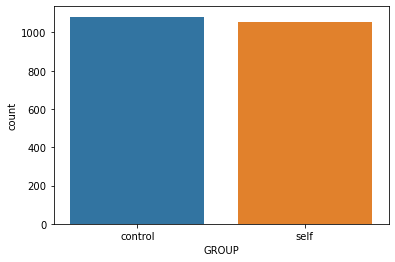

In [14]:
sns.countplot(x="GROUP",data=df_tam)

In [6]:
df_tam.columns

Index(['STIMULI', 'PARTICIPANT', 'DURATION', 'fixation_validation',
       'total_fixation_duration', 'total_fixation_count',
       'right_pupil_dilation_validation', 'left_pupil_dilation_validation',
       'total_saccade_second', 'fixation_duration_per_count', 'GROUP', 'TYPE',
       'GENDER', 'EMOTION', 'RESPONSE', 'ACCURACY'],
      dtype='object')

In [24]:
df_tam.groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].describe().T

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\3382380661.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].describe().T


GROUP                               control          self
total_fixation_count    count      1082.000      1056.000
                        mean   65301021.818  68123158.833
                        std    34433848.739  34650417.668
                        min      556659.000   6983496.000
                        25%    33995072.250  34587270.750
                        50%    62727093.000  66182065.500
                        75%    89772841.500  95698808.250
                        max   153877200.000 152519460.000
total_fixation_duration count      1082.000      1056.000
                        mean   27711522.883  28884051.646
                        std    15029803.813  14962327.422
                        min      253386.475   3326679.301
                        25%    14629715.494  14862734.457
                        50%    26121032.323  27926755.998
                        75%    38175816.188  39744513.230
                        max    77287201.318  71552753.962
total_saccade_second    count      1082.000      1056.000
                        mean   14100462.027  14715619.190
                        std     7422364.406   7467597.180
                        min      124560.459   1541554.165
                        25%     7424467.396   7566366.153
                        50%    13476621.100  14289277.601
                        75%    19396787.942  20687783.526
                        max    33219865.304  32337875.455

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\690272895.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean().plot(kind="bar")


<AxesSubplot:xlabel='GROUP'>

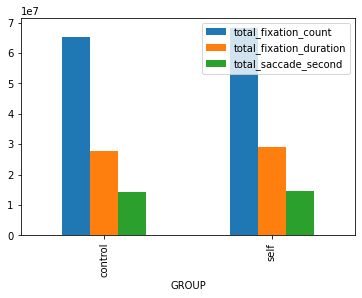

In [16]:
df_tam.groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean().plot(kind="bar")

In [17]:
df_tam.groupby(["GENDER"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\1166228337.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["GENDER"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean()


,total_fixation_count,total_fixation_duration,total_saccade_second
GENDER,,,
F,67647820.476,28740023.913,14618901.080
M,65922774.885,27926522.787,14230402.578


In [18]:
df_tam.groupby(["ACCURACY"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean()

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\3567096467.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.groupby(["ACCURACY"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean()


,total_fixation_count,total_fixation_duration,total_saccade_second
ACCURACY,,,
0,63779531.396,27085314.200,13774374.765
1,69944836.253,29634299.894,15106501.897


●	Differences in eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for accurate trials.

In [23]:
df_tam.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].describe().T

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\236362641.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].describe().T


GROUP                               control          self
total_fixation_count    count       512.000       499.000
                        mean   70737638.740  69131379.593
                        std    35298508.026  35661054.693
                        min      866640.000  12152800.000
                        25%    41990892.500  34250223.000
                        50%    67143417.500  66103072.000
                        75%    98434789.500  98558317.000
                        max   153877200.000 152519460.000
total_fixation_duration count       512.000       499.000
                        mean   29984991.800  29274471.726
                        std    15490913.483  15443556.654
                        min      438301.709   4942520.738
                        25%    17262218.324  14432064.740
                        50%    28176825.606  27782757.844
                        75%    41786083.872  41850053.359
                        max    73707737.363  71552753.962
total_saccade_second    count       512.000       499.000
                        mean   15270677.807  14938048.859
                        std     7613782.147   7689967.977
                        min      188392.431   2593448.036
                        25%     8998942.553   7374619.401
                        50%    14715326.769  14064611.674
                        75%    21541543.769  21662893.063
                        max    32933531.910  32336440.443

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_8916\2013313035.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_tam.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean().plot(kind="bar")


<AxesSubplot:xlabel='GROUP'>

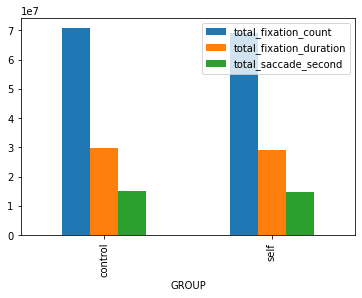

In [20]:
df_tam.query("ACCURACY==1").groupby(["GROUP"])["total_fixation_count","total_fixation_duration","total_saccade_second"].mean().plot(kind="bar")

2.	Main effects and interactions in terms of eye behaviors (fixation counts, fixation duration and saccades/secs) between two groups for all trials, conditions, genders and accuracy scores. (ANOVA, Post hoc, T-Tests, Correlation)

In [25]:
korr = df_tam.corr(method="spearman")

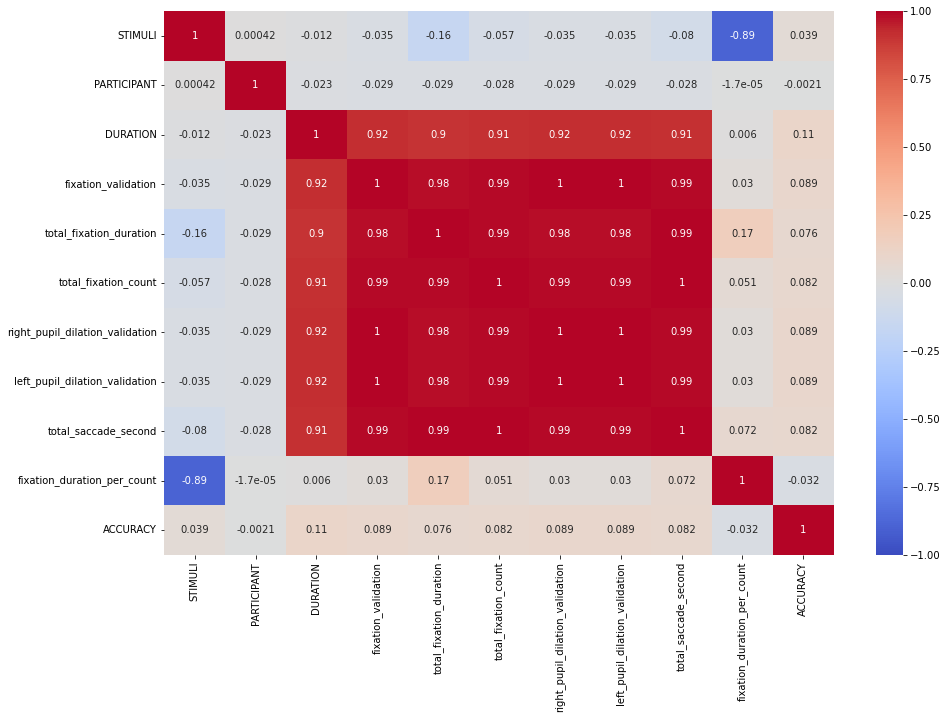

In [26]:
plt.figure(figsize = (15,10))
sns.heatmap(korr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [88]:
korr[["fixation_validation","total_fixation_duration","total_fixation_count"]]

,fixation_validation,total_fixation_duration,total_fixation_count
STIMULI,-0.035,-0.163,-0.057
PARTICIPANT,-0.029,-0.029,-0.028
DURATION,0.920,0.900,0.912
fixation_validation,1.000,0.978,0.989
total_fixation_duration,0.978,1.000,0.991
total_fixation_count,0.989,0.991,1.000
right_pupil_dilation_validation,1.000,0.978,0.989
left_pupil_dilation_validation,1.000,0.978,0.989
total_saccade_second,0.991,0.993,0.999
fixation_duration_per_count,0.030,0.167,0.051


In [27]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
# Define the ANOVA model using the formula interface
model = ols('total_saccade_second ~ GROUP', data=df_tam).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

                         sum_sq       df     F  PR(>F)
GROUP       202234687363310.281    1.000 3.649   0.056
Residual 118385987409371264.000 2136.000   NaN     NaN


In [29]:
# Define the ANOVA model using the formula interface
model = ols('fixation_duration_per_count ~ GROUP', data=df_tam).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

          sum_sq       df     F  PR(>F)
GROUP      0.000    1.000 0.008   0.929
Residual   2.133 2136.000   NaN     NaN


In [30]:
# Define the ANOVA model using the formula interface
model = ols('total_fixation_count ~ GROUP', data=df_tam).fit()

# Print ANOVA table
print(sm.stats.anova_lm(model, typ=2))

                          sum_sq       df     F  PR(>F)
GROUP       4256372887670453.500    1.000 3.568   0.059
Residual 2548418098116933632.000 2136.000   NaN     NaN


Since the p-value is greater than 0.05 for all tests hence we cannot reject the null hypothesis. 
This implies that we have not sufficient proof to say that there exists a difference in the (fixation counts, fixation duration and saccades/secs among 2 different groups

## Machine Learning

In [38]:
df_tam.isna().sum()

STIMULI                            0
PARTICIPANT                        0
DURATION                           0
fixation_validation                0
total_fixation_duration            0
total_fixation_count               0
right_pupil_dilation_validation    0
left_pupil_dilation_validation     0
total_saccade_second               0
fixation_duration_per_count        0
GROUP                              0
TYPE                               0
GENDER                             0
EMOTION                            0
RESPONSE                           0
ACCURACY                           0
dtype: int64

In [40]:
df_tam.duplicated().sum()

0

In [41]:
df_tam.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2137
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   STIMULI                          2138 non-null   int64  
 1   PARTICIPANT                      2138 non-null   int64  
 2   DURATION                         2138 non-null   float64
 3   fixation_validation              2138 non-null   float64
 4   total_fixation_duration          2138 non-null   float64
 5   total_fixation_count             2138 non-null   int64  
 6   right_pupil_dilation_validation  2138 non-null   float64
 7   left_pupil_dilation_validation   2138 non-null   float64
 8   total_saccade_second             2138 non-null   float64
 9   fixation_duration_per_count      2138 non-null   float64
 10  GROUP                            2138 non-null   object 
 11  TYPE                             2138 non-null   object 
 12  GENDER              

In [42]:
df_tam.describe()

,STIMULI,PARTICIPANT,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second,fixation_duration_per_count,ACCURACY
count,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000,2138.000
mean,16.512,42.714,21.598,1024.358,28290657.763,66694930.465,1024.358,1024.358,14404300.177,0.423,0.473
std,9.227,23.750,10.103,515.669,15004466.543,34561728.674,515.669,515.669,7449352.373,0.032,0.499
min,1.000,1.000,0.133,9.000,253386.475,556659.000,9.000,9.000,124560.459,0.377,0.000
25%,9.000,22.000,10.166,546.000,14796602.862,34408719.000,546.000,546.000,7477807.373,0.407,0.000
50%,17.000,43.000,20.191,993.500,26971206.379,64316515.500,993.500,993.500,13892302.680,0.417,0.000
75%,24.750,64.000,29.670,1409.250,38971254.354,92894512.000,1409.250,1409.250,20088067.836,0.431,1.000
max,32.000,83.000,37.330,2116.000,77287201.318,153877200.000,2116.000,2116.000,33219865.304,0.506,1.000


In [34]:
#Split the data

In [32]:
y = df_tam.RESPONSE

In [43]:
y.value_counts()

HAPPY      672
NEUTRAL    581
SAD        522
ANGRY      363
Name: RESPONSE, dtype: int64

In [33]:
X = df_tam.drop(["RESPONSE"],axis=1)

In [35]:
X.head()

,STIMULI,PARTICIPANT,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second,fixation_duration_per_count,GROUP,TYPE,GENDER,EMOTION,ACCURACY
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734,0.506,control,High,F,SAD,1
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102,0.506,self,High,F,SAD,0
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850,0.506,self,High,F,NEUTRAL,0
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771,0.506,self,High,F,ANGRY,0
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852,0.506,self,High,M,NEUTRAL,1


In [36]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2138 entries, 0 to 2137
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   STIMULI                          2138 non-null   int64  
 1   PARTICIPANT                      2138 non-null   int64  
 2   DURATION                         2138 non-null   float64
 3   fixation_validation              2138 non-null   float64
 4   total_fixation_duration          2138 non-null   float64
 5   total_fixation_count             2138 non-null   int64  
 6   right_pupil_dilation_validation  2138 non-null   float64
 7   left_pupil_dilation_validation   2138 non-null   float64
 8   total_saccade_second             2138 non-null   float64
 9   fixation_duration_per_count      2138 non-null   float64
 10  GROUP                            2138 non-null   object 
 11  TYPE                             2138 non-null   object 
 12  GENDER              

In [47]:
X_cat = pd.get_dummies(X,drop_first=True)

In [48]:
X_cat.head()

,STIMULI,PARTICIPANT,DURATION,fixation_validation,total_fixation_duration,total_fixation_count,right_pupil_dilation_validation,left_pupil_dilation_validation,total_saccade_second,fixation_duration_per_count,ACCURACY,GROUP_self,TYPE_Low,GENDER_M,EMOTION_HAPPY,EMOTION_NEUTRAL,EMOTION_SAD
0,1,1,35.732,1933.000,70603100.259,139601260,1933.000,1933.000,30346880.734,0.506,1,0,0,0,0,0,1
1,1,2,32.643,1739.000,63517222.634,125590580,1739.000,1739.000,27301203.102,0.506,0,1,0,0,0,0,1
2,1,4,16.332,785.000,28672236.784,56692700,785.000,785.000,12324004.850,0.506,0,1,0,0,0,1,0
3,1,5,7.196,365.000,13331676.976,26360300,365.000,365.000,5730269.771,0.506,0,1,0,0,0,0,0
4,1,7,19.896,1110.000,40542908.064,80164200,1110.000,1110.000,17426299.852,0.506,1,1,0,1,0,1,0


In [54]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_cat,y,test_size=0.2,random_state=0)

In [ ]:
#Build the classification model

In [49]:
import lightgbm

In [52]:
from lightgbm import LGBMClassifier

In [53]:
model = LGBMClassifier()

In [57]:
model.fit(X_train,y_train)

LGBMClassifier()

In [58]:
y_pred = model.predict(X_test)

In [59]:
from sklearn.metrics import confusion_matrix,classification_report

In [60]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       ANGRY       0.80      0.59      0.68        74
       HAPPY       0.83      0.85      0.84       139
     NEUTRAL       0.73      0.82      0.77       116
         SAD       0.81      0.83      0.82        99

    accuracy                           0.79       428
   macro avg       0.79      0.77      0.78       428
weighted avg       0.79      0.79      0.79       428



In [85]:
confusion_matrix(y_test,y_pred)

array([[ 44,   7,  14,   9],
       [  6, 118,  13,   2],
       [  1,  12,  95,   8],
       [  4,   5,   8,  82]], dtype=int64)

In [78]:
df_feature_importance = (
    pd.DataFrame({
        'feature': model.feature_name_,
        'importance': model.feature_importances_,
    })
    .sort_values('importance', ascending=False)
)

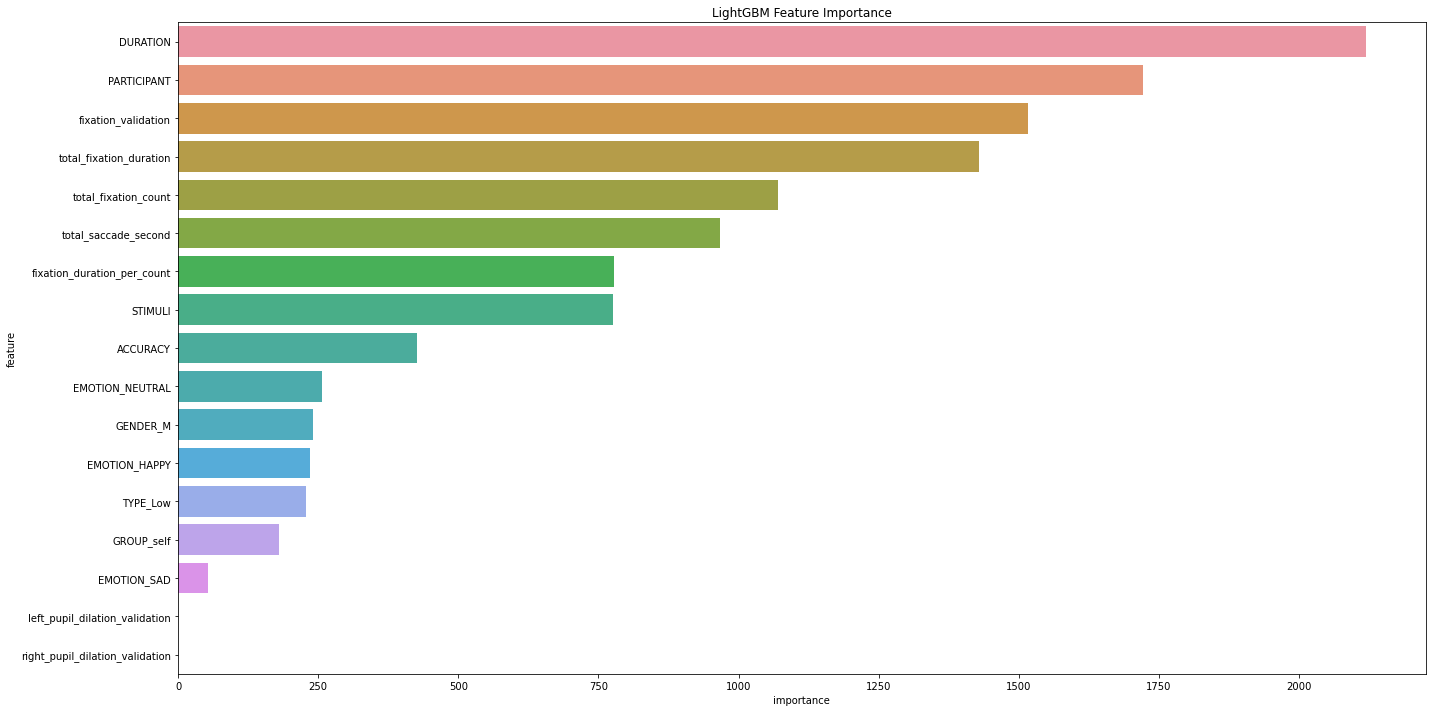

In [84]:
plt.figure(figsize=(20, 10))
sns.barplot(y=df_feature_importance.feature, x=df_feature_importance.importance, data=df_feature_importance.sort_values(by="importance", 
                                                        ascending=False), orient='h')

plt.title('LightGBM Feature Importance')
plt.tight_layout()
plt.show()